In [8]:
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModel

from sklearn.model_selection import train_test_split

import torch
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

In [9]:
df = pd.read_csv("movie_review.csv") 
df.head(5)

,fold_id,cv_tag,html_id,sent_id,text,tag
0,0,cv000,29590,0,films adapted from comic books have had plenty...,pos
1,0,cv000,29590,1,"for starters , it was created by alan moore ( ...",pos
2,0,cv000,29590,2,to say moore and campbell thoroughly researche...,pos
3,0,cv000,29590,3,"the book ( or "" graphic novel , "" if you will ...",pos
4,0,cv000,29590,4,"in other words , don't dismiss this film becau...",pos


In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained('distilbert/distilbert-base-uncased')
model = AutoModel.from_pretrained("distilbert/distilbert-base-uncased")#.to(device)

In [10]:
# y labels

labels = df['tag'].apply((lambda x: 0 if x == 'pos' else 1))

In [14]:
# splitting train and test

train_text, val_text, train_labels, val_labels = train_test_split(df['text'], labels, 
                                                                    random_state=42, 
                                                                    test_size=0.3, 
                                                                    stratify=labels)

<Axes: >

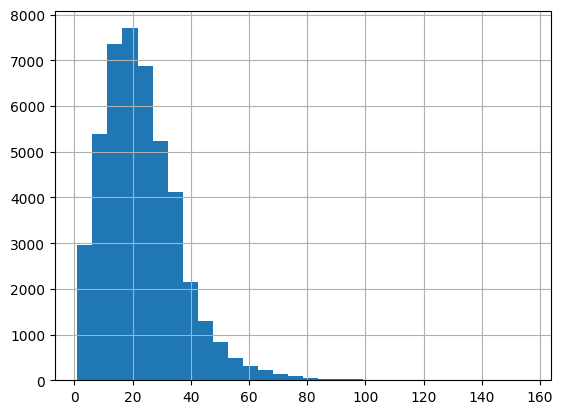

In [15]:
# sentence lengths

seq_len = [len(i.split()) for i in train_text]
pd.Series(seq_len).hist(bins = 30)

In [134]:
# tokenizing the text

tokenized_train = tokenizer(train_text.tolist(), max_length = 30, padding=True, truncation=True, return_tensors='pt')
tokenized_val = tokenizer(val_text.tolist(), max_length = 30, padding=True, truncation=True, return_tensors='pt')

In [135]:
train_seq = tokenized_train['input_ids']
train_mask = tokenized_train['attention_mask']
train_y = torch.tensor(train_labels.tolist())

val_seq = tokenized_val['input_ids']
val_mask = tokenized_val['attention_mask']
val_y = torch.tensor(val_labels.tolist())

In [136]:
batch_size = 128
train_data = TensorDataset(train_seq, train_mask, train_y)
val_data = TensorDataset(val_seq, val_mask, val_y)
train_size = len(train_data)

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

In [17]:
class FCNN(nn.Module):

    def __init__(self, bert):
        super().__init__()
        self.bert = bert 
        self.network = nn.Sequential(
            nn.Linear(768, 512),
            nn.ReLU(),
#             nn.BatchNorm1d(1024),
            nn.Dropout(p=0.1),
            nn.Linear(512, 1),
#             nn.ReLU(),
#             nn.BatchNorm1d(256),
#             nn.Dropout(p=0.1),
#             nn.Linear(256, 64),
#             nn.ReLU(),
#             nn.BatchNorm1d(64),
#             nn.Dropout(p=0.1),
#             nn.Linear(64, 2),
            )
    def forward(self, sent_id, mask):
        with torch.no_grad():
            feature = self.bert(input_ids=sent_id, attention_mask=mask).last_hidden_state[:,0,:]
        return torch.sigmoid(self.network(feature))

In [27]:
model_ft = FCNN(bert=model)#.to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model_ft.parameters(), lr=1e-3)

In [139]:
train_loss = []
train_accuracy = []
val_accuracy = []
val_loss = []
history = dict()
model.train()
for epoch in range(20):
    model.train()
    running_training_loss = 0.0
    running_training_accuracy = 0.0
    total_training_predictions = 0

    for i, data in enumerate(train_dataloader, 0):
        sent_id, mask, labels = data[0].to(device), data[1].to(device), data[2].to(device)
        optimizer.zero_grad()
        outputs = model_ft(sent_id, mask).flatten()
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()

        running_training_loss += loss.item()*sent_id.size(0)

        predicted = (outputs >= 0.5).float()
        total_training_predictions += labels.size(0)
        running_training_accuracy += (predicted == labels).sum().item()
    epoch_training_accuracy = running_training_accuracy / train_size*100
    epoch_training_loss = running_training_loss / train_size

    train_loss.append(epoch_training_loss)
    train_accuracy.append(epoch_training_accuracy)

    model.eval()
    correct = 0
    total = 0
    running_val_loss = 0.0

    with torch.no_grad():
        for data in val_dataloader:
            sent_id, mask, labels = data[0].to(device), data[1].to(device), data[2].to(device)
            outputs = model_ft(sent_id, mask).flatten()
            
            loss = criterion(outputs, labels.float())

            predicted = (outputs >= 0.5).float()
            running_val_loss += loss.item()*sent_id.size(0)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        epoch_val_accuracy = correct / total *100
        epoch_val_loss = running_val_loss / total
        val_accuracy.append(epoch_val_accuracy)
        val_loss.append(epoch_val_loss)
    print('Epoch:[%d], training accuracy: %.1f, training loss: %.3f, val accuracy: %.1f, val loss: %.3f,' %
          (epoch + 1,epoch_training_accuracy, epoch_training_loss, epoch_val_accuracy, epoch_val_loss))

history['train_loss'] = train_loss
history['train_accuracy'] = train_accuracy
history['val_accuracy'] = val_accuracy
history['val_loss'] = val_loss

accuracy = 100 * correct / total
print('Accuracy of the network on test images: %d %%' % (accuracy))

Epoch:[1], training accuracy: 61.9, training loss: 0.649, val accuracy: 63.1, val loss: 0.636,
Epoch:[2], training accuracy: 63.5, training loss: 0.636, val accuracy: 64.0, val loss: 0.629,
Epoch:[3], training accuracy: 63.9, training loss: 0.631, val accuracy: 64.0, val loss: 0.628,
Epoch:[4], training accuracy: 64.5, training loss: 0.627, val accuracy: 64.0, val loss: 0.631,
Epoch:[5], training accuracy: 64.5, training loss: 0.626, val accuracy: 63.3, val loss: 0.633,
Epoch:[6], training accuracy: 65.0, training loss: 0.622, val accuracy: 64.5, val loss: 0.626,
Epoch:[7], training accuracy: 65.2, training loss: 0.619, val accuracy: 64.6, val loss: 0.623,
Epoch:[8], training accuracy: 65.7, training loss: 0.618, val accuracy: 64.7, val loss: 0.622,
Epoch:[9], training accuracy: 65.8, training loss: 0.614, val accuracy: 64.7, val loss: 0.628,
Epoch:[10], training accuracy: 65.9, training loss: 0.613, val accuracy: 65.0, val loss: 0.623,
Epoch:[11], training accuracy: 66.1, training los

In [140]:
# filepath = '/kaggle/working/model.pth'
# torch.save(model_ft.state_dict(), filepath)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model_ft = FCNN(bert=model)
# model_ft.load_state_dict(torch.load('model.pth'))

In [66]:
test = ['This is good', 'Disappointing', 'Wonderfully great']
tokenized_test =  tokenizer(test, max_length = 30, padding=True, truncation=True, return_tensors='pt')
outputs = model_ft(tokenized_test['input_ids'], tokenized_test['attention_mask']).flatten()
print([labels[label.item()] for label in (outputs >= 0.5).float()])

['Positive', 'Negative', 'Positive']


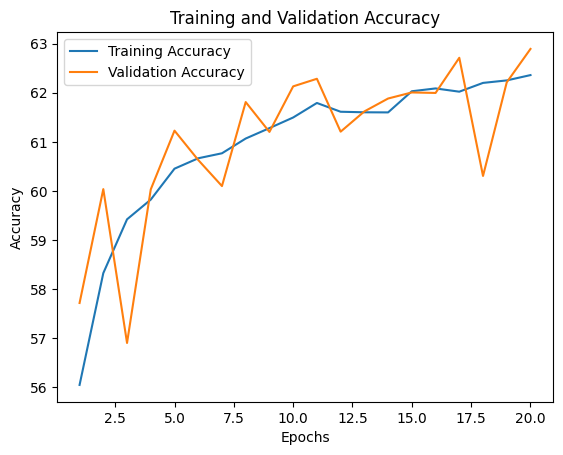

In [45]:
train_acc = history['train_accuracy']
val_acc = history['val_accuracy']

plt.plot(range(1, len(train_acc) + 1), train_acc, label='Training Accuracy')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

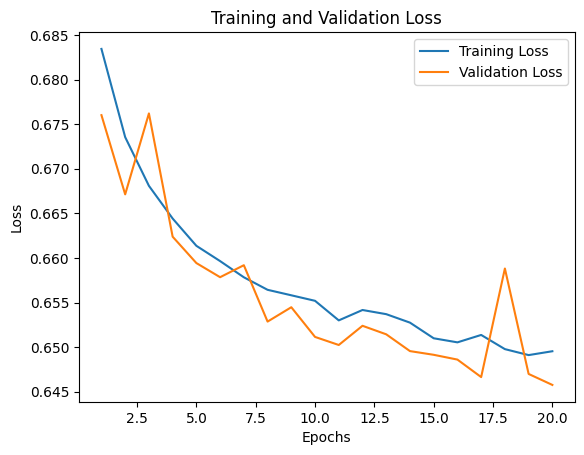

In [46]:
train_loss = history['train_loss']
val_loss = history['val_loss']

plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()